# Word to Vector(word2vec)

> ## Embedding

# I. 말뭉치(Corpus) 생성

In [1]:
import warnings
warnings.filterwarnings('ignore')

* 말뭉치 List

In [2]:
corpus = ['왕 강함 남자', 
          '여왕 아름다운 여자', 
          '소년 젊은 남자',
          '소녀 젊은 여자',
          '왕자 젊은 왕',
          '공주 젊은 여왕',
          '남자 강함', 
          '여자 아름다운',
          '왕자 소년 왕',
          '공주 소녀 여왕']

In [3]:
for text in corpus:
    print(text)

왕 강함 남자
여왕 아름다운 여자
소년 젊은 남자
소녀 젊은 여자
왕자 젊은 왕
공주 젊은 여왕
남자 강함
여자 아름다운
왕자 소년 왕
공주 소녀 여왕


# II. 'DATA' List 생성

* Before Split

In [4]:
corpus[0]

'왕 강함 남자'

* Split

In [5]:
sentences = []

for sentence in corpus:
    sentences.append(sentence.split(' '))
    
WINDOW_SIZE = 2

DATA = []

for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0):min(idx + WINDOW_SIZE, len(sentence)) + 1]: 
            if neighbor != word:
                DATA.append([word, neighbor])


* After Split

In [6]:
# input = word(중심단어) = x
# label = neighbor(주변단어) = y
DATA[:6]

[['왕', '강함'],
 ['왕', '남자'],
 ['강함', '왕'],
 ['강함', '남자'],
 ['남자', '왕'],
 ['남자', '강함']]

# III. 'DF' DataFrame 생성

> ## 1) pd.DataFrame( )

In [7]:
import pandas as pd

DF = pd.DataFrame(DATA, columns = ['INPUT', 'LABEL'])
# input = word(중심단어) = x
# label = neighbor(주변단어) = y
DF.head(5)

,INPUT,LABEL
0,왕,강함
1,왕,남자
2,강함,왕
3,강함,남자
4,남자,왕


> ## 2) 'X_test' & 'X_label' 지정

* 'X_test' - 한글

In [8]:
X_test = DF.INPUT.unique()

print(X_test)

['왕' '강함' '남자' '여왕' '아름다운' '여자' '소년' '젊은' '소녀' '왕자' '공주']


* 'X_label' - 영어

In [9]:
X_label = ['King', 'Strong', 'Man', 'Queen', 'Beautiful', 'Woman', 'Boy', 'Young', 'Girl', 'Prince', 'Princess']

print(X_label)

['King', 'Strong', 'Man', 'Queen', 'Beautiful', 'Woman', 'Boy', 'Young', 'Girl', 'Prince', 'Princess']


> ## 3) String to Integer

* 'DF' DataFrame

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

DF.INPUT = encoder.fit_transform(DF.INPUT)
DF.LABEL = encoder.fit_transform(DF.LABEL)

In [11]:
DF.head()

,INPUT,LABEL
0,8,0
1,8,2
2,0,8
3,0,2
4,2,8


> ## 4) One-Hot-Encoding

* 'X_train' and 'y_train'

In [12]:
from tensorflow.keras.utils import to_categorical

X_train = to_categorical(DF.INPUT.values)
y_train = to_categorical(DF.LABEL.values)

In [13]:
print(X_train[0], y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


* Shape

In [14]:
print(X_train.shape, y_train.shape)

(52, 11) (52, 11)


# IV. Embedding

> ## 1) Model 'autoencoder' Define

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers

encoding_dim = 2

input_txt = layers.Input(shape = (11, ))
encoded = layers.Dense(32, activation = 'relu')(input_txt)
encoded = layers.Dense(encoding_dim, activation = 'relu')(encoded)  # 2차원 벡터라이징

decoded = layers.Dense(32, activation = 'relu')(encoded)
# softmax가 아닌 이유 : 분류가 아닌, 각 레이어에 들어간 인풋에 대한 레이블의 참거짓을 판별하는 것
decoded = layers.Dense(11, activation = 'sigmoid')(decoded) 


autoencoder = models.Model(input_txt, decoded)

* Model Information

In [16]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 32)                384       
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
 dense_2 (Dense)             (None, 32)                96        
                                                                 
 dense_3 (Dense)             (None, 11)                363       
                                                                 
Total params: 909
Trainable params: 909
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model 'word2vec' Define

In [17]:
# functional model
word2vec = models.Model(input_txt, encoded) # input layer, output layer

* Model Information

In [18]:
word2vec.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 32)                384       
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


> ## 3) Model Compile

In [19]:
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam')

> ## 4) Model fit

* 약 3분

In [20]:
%%time

autoencoder.fit(X_train, y_train,
                epochs = 3500,
                batch_size = 2,
                verbose = 0)

CPU times: total: 3.33 s
Wall time: 1min 27s


# V. 'word2vec' 적용

> ## 1) 'X_test' Integer Encoding

In [21]:
print(X_test)

['왕' '강함' '남자' '여왕' '아름다운' '여자' '소년' '젊은' '소녀' '왕자' '공주']


In [22]:
X_test = encoder.fit_transform(X_test)

In [23]:
print(X_test)

[ 8  0  2  6  5  7  4 10  3  9  1]


> ## 2) 'X_test' One-Hot-Encoding

In [24]:
from tensorflow.keras.utils import to_categorical

X_test = to_categorical(X_test)

In [25]:
print(X_test)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


> ## 3) 'word2vec' Embedding

> ### (1) Embedding 적용

In [26]:
embedding_txt = word2vec.predict(X_test, verbose = 0)

embedding_txt.shape

(11, 2)

> ### (2) Embedding 결과

In [27]:
embedding_txt

array([[ 0.        ,  2.4026952 ],
       [20.71992   ,  0.        ],
       [ 0.        ,  7.318394  ],
       [ 2.627424  ,  3.8489697 ],
       [ 9.026171  , 21.496626  ],
       [ 4.810749  ,  6.542302  ],
       [ 6.1757812 ,  0.28448996],
       [ 0.7303003 ,  1.388411  ],
       [ 5.136054  ,  9.071893  ],
       [11.495476  ,  5.401353  ],
       [10.210457  , 11.308054  ]], dtype=float32)

> ### (3) 'word2vec_DF' DataFrame

In [28]:
word2vec_DF = pd.DataFrame(embedding_txt, columns = ['x1', 'x2'])
word2vec_DF['word'] = X_label #np.array(list(word2int.keys()))
word2vec_DF = word2vec_DF[['word', 'x1', 'x2']]

word2vec_DF

,word,x1,x2
0,King,0.000000,2.402695
1,Strong,20.719919,0.000000
2,Man,0.000000,7.318394
3,Queen,2.627424,3.848970
4,Beautiful,9.026171,21.496626
5,Woman,4.810749,6.542302
6,Boy,6.175781,0.284490
7,Young,0.730300,1.388411
8,Girl,5.136054,9.071893
9,Prince,11.495476,5.401353


> ### (4) Visualization

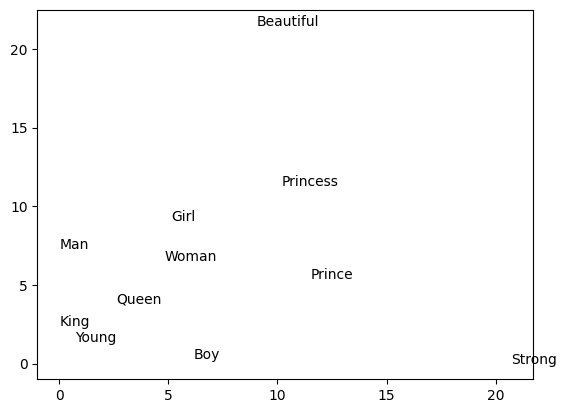

In [29]:
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np

fig, ax = plt.subplots()

for word, x1, x2 in zip(word2vec_DF['word'], 
                        word2vec_DF['x1'], 
                        word2vec_DF['x2']):
    ax.annotate(word, (x1, x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(embedding_txt, axis=0)[0] - PADDING
y_axis_min = np.amin(embedding_txt, axis=0)[1] - PADDING
x_axis_max = np.amax(embedding_txt, axis=0)[0] + PADDING
y_axis_max = np.amax(embedding_txt, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.rcParams["figure.figsize"] = (7, 7)

plt.show()

# 
# 
# 
# The End
# 
# 
# 